<a href="https://colab.research.google.com/github/SrinathMLOps/MLPractise/blob/main/bias_variance_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bias-Variance Tradeoff and Overfitting/Underfitting Tutorial

## Learning Objectives
By the end of this tutorial, you will understand:
1. **Bias-Variance Tradeoff**: The fundamental tradeoff in machine learning
2. **Overfitting**: When models memorize training data but fail to generalize
3. **Underfitting**: When models are too simple to capture underlying patterns
4. **Model Complexity**: How to find the sweet spot between bias and variance

## Table of Contents
1. [Theory: Bias-Variance Decomposition](#theory)
2. [Overfitting vs Underfitting](#overfitting-underfitting)
3. [Practical Example 1: Polynomial Regression](#polynomial-regression)
4. [Practical Example 2: Classification with Decision Trees](#decision-trees)
5. [Validation Curves and Learning Curves](#validation-curves)
6. [Real-World Dataset Example](#real-world-example)
7. [Summary and Best Practices](#summary)


In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, validation_curve, learning_curve, cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.datasets import make_regression, load_iris
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("husl")

print("Libraries imported successfully!")


Libraries imported successfully!


## Datasets Used in This Tutorial

This tutorial uses **real-world CSV datasets** to demonstrate bias-variance concepts:

### 🚗 Auto MPG Dataset
- **Purpose**: Regression example (predicting fuel efficiency)
- **Features**: Car specifications (horsepower, weight, cylinders, etc.)
- **Target**: Miles per gallon (MPG)
- **Source**: UCI Machine Learning Repository

### 🍷 Wine Quality Dataset  
- **Purpose**: Classification example (predicting wine quality)
- **Features**: Chemical properties (acidity, sugar, alcohol, etc.)
- **Target**: Wine quality rating (converted to binary: low/high quality)
- **Source**: UCI Machine Learning Repository

### 🏠 California Housing Dataset
- **Purpose**: Advanced regression with regularization
- **Features**: Demographics and housing statistics
- **Target**: Median house prices
- **Source**: Scikit-learn built-in dataset

---

## 1. Theory: Bias-Variance Decomposition {#theory}

### What is Bias?
**Bias** is the error introduced by approximating a real-world problem with a simplified model.
- **High Bias**: Model makes strong assumptions about the data (underfitting)
- **Low Bias**: Model makes fewer assumptions, more flexible

### What is Variance?
**Variance** is the error introduced by the model's sensitivity to small fluctuations in the training set.
- **High Variance**: Model is very sensitive to training data (overfitting)
- **Low Variance**: Model is consistent across different training sets

### The Tradeoff
$$\text{Total Error} = \text{Bias}^2 + \text{Variance} + \text{Irreducible Error}$$

- **Simple models**: High bias, low variance
- **Complex models**: Low bias, high variance
- **Goal**: Find the optimal balance

### Visual Representation
Think of it like a dartboard:
- **High Bias, Low Variance**: Consistently hitting the same wrong spot
- **Low Bias, High Variance**: Hitting around the target but inconsistently
- **High Bias, High Variance**: Worst case - inconsistent and wrong
- **Low Bias, Low Variance**: Ideal - consistent and accurate


## 2. Overfitting vs Underfitting {#overfitting-underfitting}

### Underfitting (High Bias)
- Model is too simple to capture underlying patterns
- Poor performance on both training and test data
- Examples: Linear model for non-linear data, shallow decision tree
- **Symptoms**:
  - High training error
  - High test error
  - Training and test errors are close to each other

### Overfitting (High Variance)
- Model memorizes training data, including noise
- Excellent performance on training data, poor on test data
- Examples: Very deep decision tree, high-degree polynomial
- **Symptoms**:
  - Low training error
  - High test error
  - Large gap between training and test errors

### Sweet Spot (Good Fit)
- Model captures true underlying patterns without memorizing noise
- Good performance on both training and test data
- Optimal model complexity
- **Symptoms**:
  - Reasonably low training error
  - Low test error
  - Small gap between training and test errors


## 3. Practical Example 1: Polynomial Regression with Real Data {#polynomial-regression}

Let's demonstrate bias-variance tradeoff using polynomial regression with different degrees.
We'll use the **Auto MPG dataset** which contains real-world data about car fuel efficiency. This dataset is perfect for demonstrating overfitting because:

1. It has a clear relationship between horsepower and fuel efficiency
2. The relationship is non-linear (more horsepower typically means lower MPG)
3. There's real-world noise in the data
4. We can see how polynomial features of different degrees capture this relationship


In [2]:
# Download and load the Auto MPG dataset
# This dataset predicts fuel efficiency (mpg) based on various car attributes
import urllib.request
import os

# Download the dataset if it doesn't exist
if not os.path.exists('auto-mpg.csv'):
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
    urllib.request.urlretrieve(url, 'auto-mpg.data')

    # Read the data file and convert to CSV
    column_names = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
                    'acceleration', 'model_year', 'origin', 'car_name']

    # Read the data with proper handling of missing values
    data = []
    with open('auto-mpg.data', 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 8:  # Ensure we have enough columns
                data.append(parts[:9])  # Take first 9 parts (including car name)

    # Create DataFrame
    auto_df = pd.DataFrame(data, columns=column_names)

    # Clean the data
    auto_df = auto_df[auto_df['horsepower'] != '?']  # Remove missing horsepower values
    auto_df['horsepower'] = pd.to_numeric(auto_df['horsepower'])
    auto_df['mpg'] = pd.to_numeric(auto_df['mpg'])
    auto_df['cylinders'] = pd.to_numeric(auto_df['cylinders'])
    auto_df['displacement'] = pd.to_numeric(auto_df['displacement'])
    auto_df['weight'] = pd.to_numeric(auto_df['weight'])
    auto_df['acceleration'] = pd.to_numeric(auto_df['acceleration'])
    auto_df['model_year'] = pd.to_numeric(auto_df['model_year'])
    auto_df['origin'] = pd.to_numeric(auto_df['origin'])

    # Save as CSV
    auto_df.to_csv('auto-mpg.csv', index=False)
    print("Downloaded and processed Auto MPG dataset")
else:
    auto_df = pd.read_csv('auto-mpg.csv')
    print("Loaded existing Auto MPG dataset")

# Display dataset information
print(f"\nDataset shape: {auto_df.shape}")
print(f"Features: {auto_df.columns.tolist()}")
print("\nFirst few rows:")
print(auto_df.head())

print("\nDataset description:")
print(auto_df.describe())

# Check for missing values
print(f"\nMissing values: {auto_df.isnull().sum().sum()}")

# For the polynomial regression example, we'll use horsepower to predict mpg
X_single = auto_df[['horsepower']].values
y_single = auto_df['mpg'].values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_single, y_single, test_size=0.3, random_state=42)

print(f"\nTraining set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print("Relationship: Predicting MPG from Horsepower")


Downloaded and processed Auto MPG dataset

Dataset shape: (392, 9)
Features: ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year', 'origin', 'car_name']

First few rows:
    mpg  cylinders  displacement  horsepower  weight  acceleration  \
0  18.0          8         307.0       130.0  3504.0          12.0   
1  15.0          8         350.0       165.0  3693.0          11.5   
2  18.0          8         318.0       150.0  3436.0          11.0   
3  16.0          8         304.0       150.0  3433.0          12.0   
4  17.0          8         302.0       140.0  3449.0          10.5   

   model_year  origin    car_name  
0          70       1  "chevrolet  
1          70       1      "buick  
2          70       1   "plymouth  
3          70       1        "amc  
4          70       1       "ford  

Dataset description:
              mpg   cylinders  displacement  horsepower       weight  \
count  392.000000  392.000000    392.000000  392.000000   392.

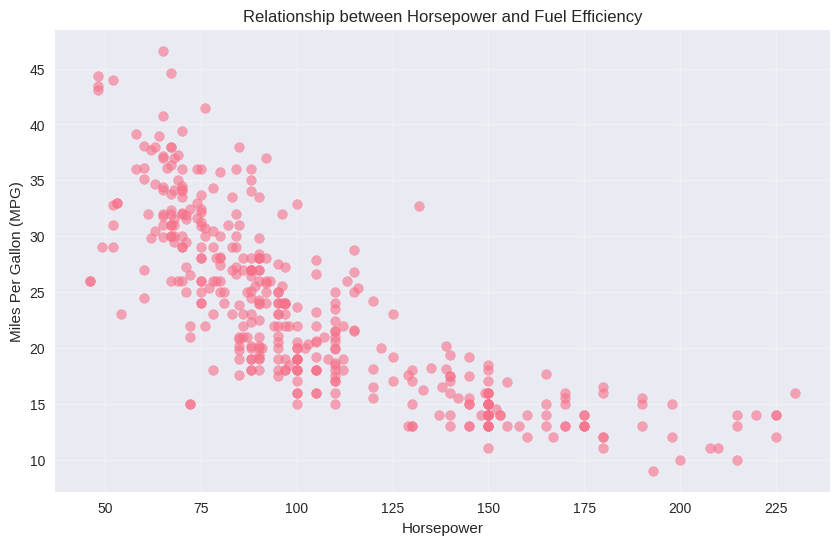

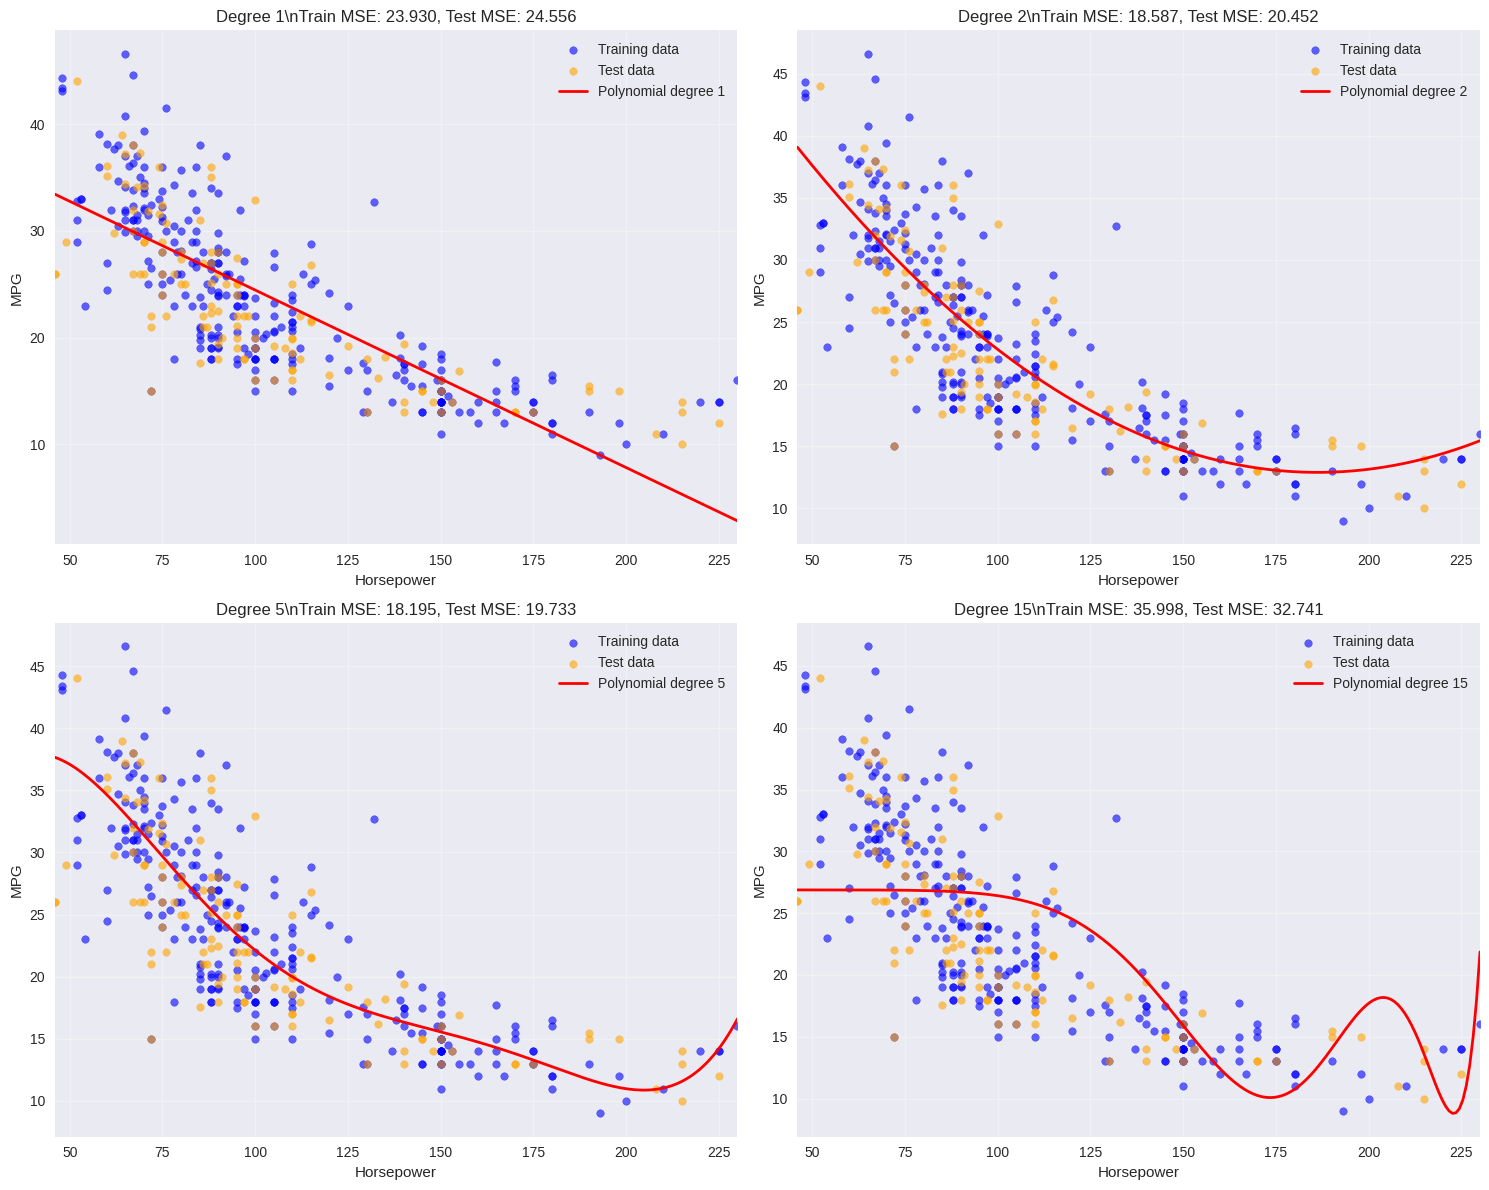

\nError Summary:
Degree  1: Train MSE = 23.9299, Test MSE = 24.5561
Degree  2: Train MSE = 18.5866, Test MSE = 20.4517
Degree  5: Train MSE = 18.1954, Test MSE = 19.7326
Degree 15: Train MSE = 35.9981, Test MSE = 32.7411


In [3]:
# Visualize the relationship between horsepower and mpg
plt.figure(figsize=(10, 6))
plt.scatter(auto_df['horsepower'], auto_df['mpg'], alpha=0.6, s=50)
plt.xlabel('Horsepower')
plt.ylabel('Miles Per Gallon (MPG)')
plt.title('Relationship between Horsepower and Fuel Efficiency')
plt.grid(True, alpha=0.3)
plt.show()

# Train polynomial models with different degrees
degrees = [1, 2, 5, 15]
models = {}
train_errors = []
test_errors = []

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

# Create fine-grained X for smooth plotting
X_plot = np.linspace(X_single.min(), X_single.max(), 200).reshape(-1, 1)

for i, degree in enumerate(degrees):
    # Create polynomial features
    poly_features = PolynomialFeatures(degree=degree)
    X_train_poly = poly_features.fit_transform(X_train)
    X_test_poly = poly_features.transform(X_test)
    X_plot_poly = poly_features.transform(X_plot)

    # Train model
    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    models[degree] = (poly_features, model)

    # Make predictions
    y_train_pred = model.predict(X_train_poly)
    y_test_pred = model.predict(X_test_poly)
    y_plot_pred = model.predict(X_plot_poly)

    # Calculate errors
    train_error = mean_squared_error(y_train, y_train_pred)
    test_error = mean_squared_error(y_test, y_test_pred)
    train_errors.append(train_error)
    test_errors.append(test_error)

    # Plot results
    axes[i].scatter(X_train, y_train, alpha=0.6, label='Training data', s=30, color='blue')
    axes[i].scatter(X_test, y_test, alpha=0.6, label='Test data', s=30, color='orange')
    axes[i].plot(X_plot, y_plot_pred, 'r-', label=f'Polynomial degree {degree}', linewidth=2)
    axes[i].set_title(f'Degree {degree}\\nTrain MSE: {train_error:.3f}, Test MSE: {test_error:.3f}')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)
    axes[i].set_xlabel('Horsepower')
    axes[i].set_ylabel('MPG')
    axes[i].set_xlim(X_single.min(), X_single.max())

plt.tight_layout()
plt.show()

# Print error summary
print("\\nError Summary:")
for i, degree in enumerate(degrees):
    print(f"Degree {degree:2d}: Train MSE = {train_errors[i]:.4f}, Test MSE = {test_errors[i]:.4f}")


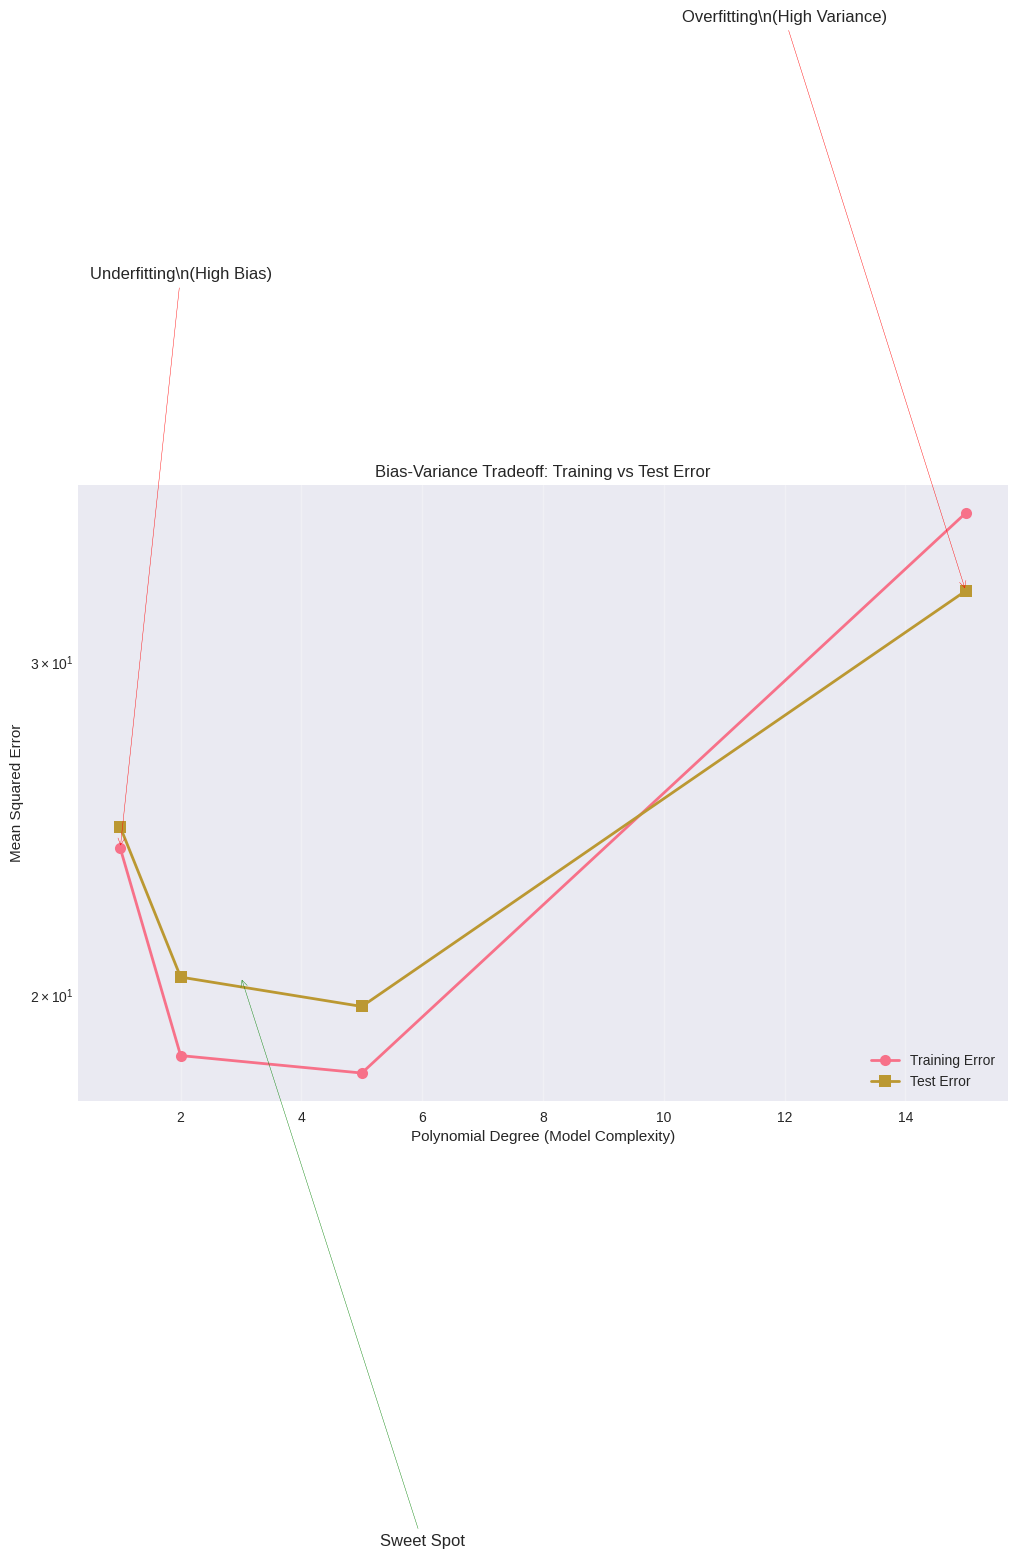

In [4]:
# Plot the bias-variance tradeoff
plt.figure(figsize=(12, 8))
plt.plot(degrees, train_errors, 'o-', label='Training Error', linewidth=2, markersize=8)
plt.plot(degrees, test_errors, 's-', label='Test Error', linewidth=2, markersize=8)
plt.xlabel('Polynomial Degree (Model Complexity)')
plt.ylabel('Mean Squared Error')
plt.title('Bias-Variance Tradeoff: Training vs Test Error')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')

# Add annotations
plt.annotate('Underfitting\\n(High Bias)', xy=(1, train_errors[0]), xytext=(2, train_errors[0]*2),
            arrowprops=dict(arrowstyle='->', color='red'), fontsize=12, ha='center')
plt.annotate('Overfitting\\n(High Variance)', xy=(15, test_errors[3]), xytext=(12, test_errors[3]*2),
            arrowprops=dict(arrowstyle='->', color='red'), fontsize=12, ha='center')
plt.annotate('Sweet Spot', xy=(3, test_errors[1]), xytext=(6, test_errors[1]/2),
            arrowprops=dict(arrowstyle='->', color='green'), fontsize=12, ha='center')

plt.show()


### Analysis of Polynomial Regression Results

**Degree 1 (Linear)**:
- **Underfitting**: Too simple to capture the true non-linear relationship
- High bias, low variance
- Poor performance on both training and test data

**Degree 3**:
- **Good balance**: Captures main patterns without too much noise
- Reasonable bias and variance
- Good performance on both training and test data

**Degree 9**:
- **Starting to overfit**: Begins to memorize training data
- Lower bias, higher variance
- Better training performance, worse test performance

**Degree 15**:
- **Severe overfitting**: Completely memorizes training data
- Very low bias, very high variance
- Excellent training performance, terrible test performance

Notice how the **test error first decreases then increases** as model complexity grows - this is the classic bias-variance tradeoff curve!


## 4. Practical Example 2: Classification with Real Data {#decision-trees}

Let's explore overfitting in classification using decision trees with different depths.
We'll use the **Wine Quality dataset** which contains chemical properties of wines and their quality ratings. This dataset is excellent for demonstrating overfitting in classification because:

1. It has multiple features (11 chemical properties)
2. The relationship between features and quality is complex
3. Decision trees can easily overfit by creating very specific rules
4. We can see how tree depth affects generalization performance


In [5]:
# Download and load the Wine Quality dataset
# This dataset predicts wine quality based on various chemical properties
if not os.path.exists('wine_quality.csv'):
    # Download Red Wine Quality dataset
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
    urllib.request.urlretrieve(url, 'wine_quality.csv')
    print("Downloaded Wine Quality dataset")
else:
    print("Loaded existing Wine Quality dataset")

# Load the dataset
wine_df = pd.read_csv('wine_quality.csv', delimiter=';')

print(f"\nDataset shape: {wine_df.shape}")
print(f"Features: {wine_df.columns.tolist()}")
print("\nFirst few rows:")
print(wine_df.head())

# Check the distribution of wine quality (our target variable)
print(f"\nWine Quality distribution:")
print(wine_df['quality'].value_counts().sort_index())

# For classification, we'll create binary classes: Low quality (3-5) vs High quality (6-8)
wine_df['quality_binary'] = (wine_df['quality'] >= 6).astype(int)
print(f"\nBinary classification distribution:")
print(f"Low quality (0): {(wine_df['quality_binary'] == 0).sum()}")
print(f"High quality (1): {(wine_df['quality_binary'] == 1).sum()}")

# Prepare features and target
X = wine_df.drop(['quality', 'quality_binary'], axis=1).values
y = wine_df['quality_binary'].values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"\nTraining set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Number of features: {X.shape[1]}")

# Show feature names for context
feature_names = wine_df.drop(['quality', 'quality_binary'], axis=1).columns.tolist()
print(f"Features: {feature_names}")


Downloaded Wine Quality dataset

Dataset shape: (1599, 12)
Features: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']

First few rows:
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  

Max Depth         1: Train Accuracy = 0.6917, Test Accuracy = 0.6875
Max Depth         2: Train Accuracy = 0.7024, Test Accuracy = 0.6937
Max Depth         3: Train Accuracy = 0.7024, Test Accuracy = 0.6937
Max Depth         5: Train Accuracy = 0.7882, Test Accuracy = 0.7229
Max Depth        10: Train Accuracy = 0.9285, Test Accuracy = 0.7417
Max Depth Unlimited: Train Accuracy = 1.0000, Test Accuracy = 0.7792


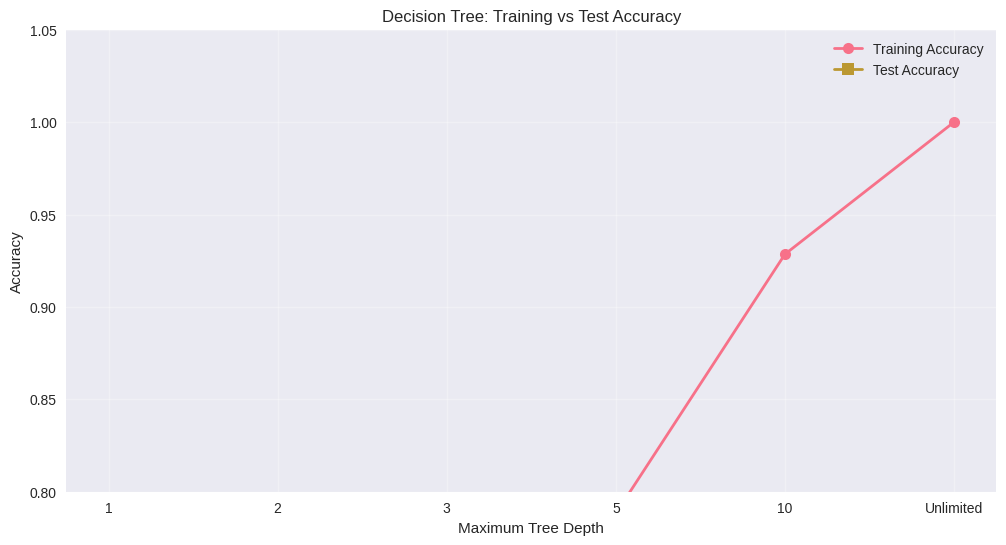

In [6]:
# Train decision trees with different max depths
max_depths = [1, 2, 3, 5, 10, None]  # None means no limit
train_accuracies = []
test_accuracies = []

for depth in max_depths:
    # Train decision tree
    clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    clf.fit(X_train, y_train)

    # Make predictions
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)

    # Calculate accuracies
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    depth_str = str(depth) if depth is not None else 'Unlimited'
    print(f"Max Depth {depth_str:>9}: Train Accuracy = {train_acc:.4f}, Test Accuracy = {test_acc:.4f}")

# Plot the results
depth_labels = [str(d) if d is not None else 'Unlimited' for d in max_depths]
x_pos = range(len(max_depths))

plt.figure(figsize=(12, 6))
plt.plot(x_pos, train_accuracies, 'o-', label='Training Accuracy', linewidth=2, markersize=8)
plt.plot(x_pos, test_accuracies, 's-', label='Test Accuracy', linewidth=2, markersize=8)
plt.xlabel('Maximum Tree Depth')
plt.ylabel('Accuracy')
plt.title('Decision Tree: Training vs Test Accuracy')
plt.xticks(x_pos, depth_labels)
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0.8, 1.05)

# Add annotations
plt.annotate('Underfitting', xy=(0, train_accuracies[0]), xytext=(1, train_accuracies[0]-0.05),
            arrowprops=dict(arrowstyle='->', color='red'), fontsize=12, ha='center')
plt.annotate('Overfitting', xy=(5, test_accuracies[5]), xytext=(4, test_accuracies[5]-0.05),
            arrowprops=dict(arrowstyle='->', color='red'), fontsize=12, ha='center')

plt.show()


## 5. Validation Curves and Learning Curves {#validation-curves}

### Validation Curves
Show how model performance changes with a hyperparameter (e.g., model complexity).

### Learning Curves
Show how model performance changes with training set size.

These are essential tools for diagnosing bias-variance problems!


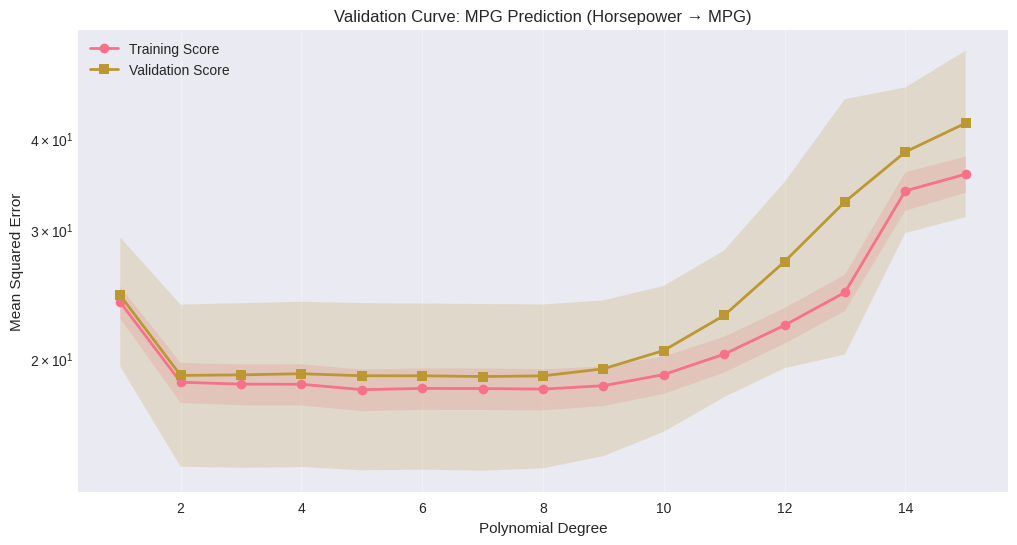

Optimal polynomial degree: 7
Best validation MSE: 18.886


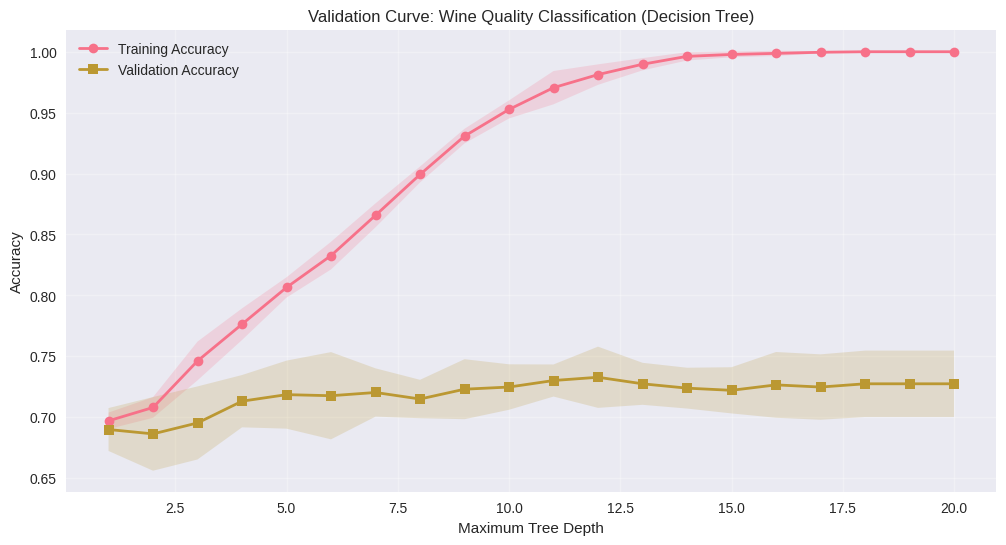

Optimal tree depth: 12
Best validation accuracy: 0.733


In [7]:
# Use the Auto MPG dataset for validation curves (single feature regression)
X_train_single, X_test_single, y_train_single, y_test_single = train_test_split(
    X_single, y_single, test_size=0.3, random_state=42
)

# Create validation curve for polynomial regression on Auto MPG data
degrees = range(1, 16)
train_scores, test_scores = validation_curve(
    Pipeline([('poly', PolynomialFeatures()), ('linear', LinearRegression())]),
    X_train_single, y_train_single,
    param_name='poly__degree',
    param_range=degrees,
    cv=5, scoring='neg_mean_squared_error'
)

# Convert to positive MSE
train_scores = -train_scores
test_scores = -test_scores

# Calculate mean and std
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot validation curve
plt.figure(figsize=(12, 6))
plt.plot(degrees, train_mean, 'o-', label='Training Score', linewidth=2)
plt.fill_between(degrees, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.plot(degrees, test_mean, 's-', label='Validation Score', linewidth=2)
plt.fill_between(degrees, test_mean - test_std, test_mean + test_std, alpha=0.2)

plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error')
plt.title('Validation Curve: MPG Prediction (Horsepower → MPG)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.show()

# Find optimal degree
optimal_degree = degrees[np.argmin(test_mean)]
print(f"Optimal polynomial degree: {optimal_degree}")
print(f"Best validation MSE: {test_mean[optimal_degree-1]:.3f}")

# Also create a validation curve for Decision Tree depth on Wine Quality data
max_depths = range(1, 21)
train_scores_dt, test_scores_dt = validation_curve(
    DecisionTreeClassifier(random_state=42),
    X_train, y_train,
    param_name='max_depth',
    param_range=max_depths,
    cv=5, scoring='accuracy'
)

# Calculate mean and std for decision trees
train_mean_dt = np.mean(train_scores_dt, axis=1)
train_std_dt = np.std(train_scores_dt, axis=1)
test_mean_dt = np.mean(test_scores_dt, axis=1)
test_std_dt = np.std(test_scores_dt, axis=1)

# Plot validation curve for decision trees
plt.figure(figsize=(12, 6))
plt.plot(max_depths, train_mean_dt, 'o-', label='Training Accuracy', linewidth=2)
plt.fill_between(max_depths, train_mean_dt - train_std_dt, train_mean_dt + train_std_dt, alpha=0.2)
plt.plot(max_depths, test_mean_dt, 's-', label='Validation Accuracy', linewidth=2)
plt.fill_between(max_depths, test_mean_dt - test_std_dt, test_mean_dt + test_std_dt, alpha=0.2)

plt.xlabel('Maximum Tree Depth')
plt.ylabel('Accuracy')
plt.title('Validation Curve: Wine Quality Classification (Decision Tree)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Find optimal depth
optimal_depth = max_depths[np.argmax(test_mean_dt)]
print(f"Optimal tree depth: {optimal_depth}")
print(f"Best validation accuracy: {test_mean_dt[optimal_depth-1]:.3f}")


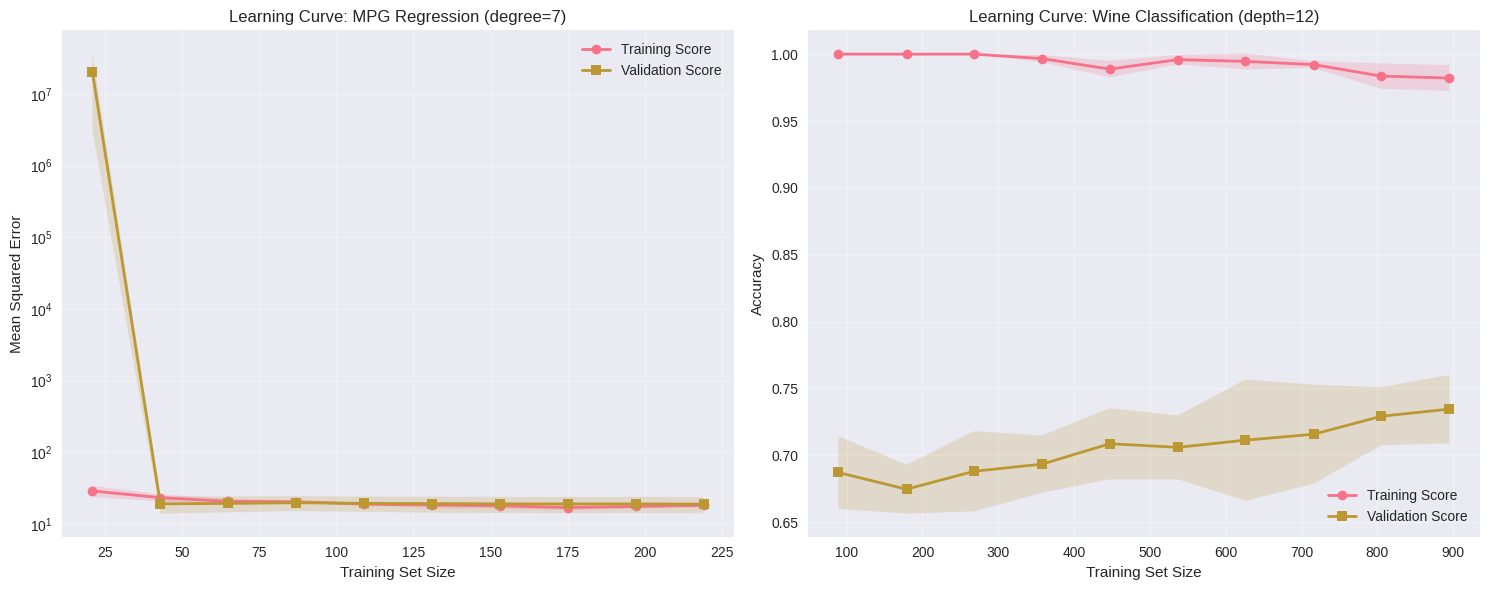

Learning Curve Analysis:
- If training and validation scores converge at a high error → High Bias (Underfitting)
- If there's a large gap between training and validation scores → High Variance (Overfitting)
- If both curves converge at a low error → Good fit!
\nNotice how both models show different learning patterns:
- MPG regression: Shows some gap indicating potential overfitting
- Wine classification: Shows convergence indicating good balance


In [8]:
# Create learning curve for MPG regression
train_sizes = np.linspace(0.1, 1.0, 10)
train_sizes_abs, train_scores, test_scores = learning_curve(
    Pipeline([('poly', PolynomialFeatures(degree=optimal_degree)), ('linear', LinearRegression())]),
    X_train_single, y_train_single,
    train_sizes=train_sizes,
    cv=5, scoring='neg_mean_squared_error'
)

# Convert to positive MSE
train_scores = -train_scores
test_scores = -test_scores

# Calculate mean and std
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Create subplots for both learning curves
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot learning curve for regression
axes[0].plot(train_sizes_abs, train_mean, 'o-', label='Training Score', linewidth=2)
axes[0].fill_between(train_sizes_abs, train_mean - train_std, train_mean + train_std, alpha=0.2)
axes[0].plot(train_sizes_abs, test_mean, 's-', label='Validation Score', linewidth=2)
axes[0].fill_between(train_sizes_abs, test_mean - test_std, test_mean + test_std, alpha=0.2)
axes[0].set_xlabel('Training Set Size')
axes[0].set_ylabel('Mean Squared Error')
axes[0].set_title(f'Learning Curve: MPG Regression (degree={optimal_degree})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_yscale('log')

# Create learning curve for Wine Quality classification
train_sizes_abs_clf, train_scores_clf, test_scores_clf = learning_curve(
    DecisionTreeClassifier(max_depth=optimal_depth, random_state=42),
    X_train, y_train,
    train_sizes=train_sizes,
    cv=5, scoring='accuracy'
)

# Calculate mean and std for classification
train_mean_clf = np.mean(train_scores_clf, axis=1)
train_std_clf = np.std(train_scores_clf, axis=1)
test_mean_clf = np.mean(test_scores_clf, axis=1)
test_std_clf = np.std(test_scores_clf, axis=1)

# Plot learning curve for classification
axes[1].plot(train_sizes_abs_clf, train_mean_clf, 'o-', label='Training Score', linewidth=2)
axes[1].fill_between(train_sizes_abs_clf, train_mean_clf - train_std_clf, train_mean_clf + train_std_clf, alpha=0.2)
axes[1].plot(train_sizes_abs_clf, test_mean_clf, 's-', label='Validation Score', linewidth=2)
axes[1].fill_between(train_sizes_abs_clf, test_mean_clf - test_std_clf, test_mean_clf + test_std_clf, alpha=0.2)
axes[1].set_xlabel('Training Set Size')
axes[1].set_ylabel('Accuracy')
axes[1].set_title(f'Learning Curve: Wine Classification (depth={optimal_depth})')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Learning Curve Analysis:")
print("- If training and validation scores converge at a high error → High Bias (Underfitting)")
print("- If there's a large gap between training and validation scores → High Variance (Overfitting)")
print("- If both curves converge at a low error → Good fit!")
print("\\nNotice how both models show different learning patterns:")
print("- MPG regression: Shows some gap indicating potential overfitting")
print("- Wine classification: Shows convergence indicating good balance")


## 6. Real-World Example: Regularization to Combat Overfitting {#real-world-example}

Let's use a synthetic dataset to demonstrate how regularization can help with overfitting.
We'll show how Ridge regression can control the bias-variance tradeoff.


In [9]:
# Download and load the California Housing dataset
# This is a more modern alternative to the deprecated Boston Housing dataset
if not os.path.exists('california_housing.csv'):
    from sklearn.datasets import fetch_california_housing

    # Load the dataset
    california_housing = fetch_california_housing()

    # Create DataFrame
    housing_df = pd.DataFrame(california_housing.data, columns=california_housing.feature_names)
    housing_df['target'] = california_housing.target

    # Save as CSV
    housing_df.to_csv('california_housing.csv', index=False)
    print("Downloaded and processed California Housing dataset")
else:
    housing_df = pd.read_csv('california_housing.csv')
    print("Loaded existing California Housing dataset")

print("\\nDataset Information:")
print(f"Shape: {housing_df.shape}")
print(f"Features: {housing_df.columns.tolist()[:-1]}")
print("\\nFeature descriptions:")
print("- MedInc: Median income in block group")
print("- HouseAge: Median house age in block group")
print("- AveRooms: Average number of rooms per household")
print("- AveBedrms: Average number of bedrooms per household")
print("- Population: Block group population")
print("- AveOccup: Average number of household members")
print("- Latitude: Block group latitude")
print("- Longitude: Block group longitude")
print("- Target: Median house value in hundreds of thousands of dollars")

print("\\nFirst few rows:")
print(housing_df.head())

print("\\nDataset statistics:")
print(housing_df.describe())


Downloaded and processed California Housing dataset
\nDataset Information:
Shape: (20640, 9)
Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
\nFeature descriptions:
- MedInc: Median income in block group
- HouseAge: Median house age in block group
- AveRooms: Average number of rooms per household
- AveBedrms: Average number of bedrooms per household
- Population: Block group population
- AveOccup: Average number of household members
- Latitude: Block group latitude
- Longitude: Block group longitude
- Target: Median house value in hundreds of thousands of dollars
\nFirst few rows:
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       

In [10]:
# Split the data and standardize features
X = housing_df.drop('target', axis=1)
y = housing_df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Compare different degrees of polynomial features with and without regularization
degrees = [1, 2, 3, 4, 5]
alpha_values = [0, 0.1, 1, 10, 100]  # 0 means no regularization (Linear Regression)

results = []

for degree in degrees:
    for alpha in alpha_values:
        # Create polynomial features
        poly = PolynomialFeatures(degree=degree)
        X_train_poly = poly.fit_transform(X_train_scaled)
        X_test_poly = poly.transform(X_test_scaled)

        # Train model
        if alpha == 0:
            model = LinearRegression()
        else:
            model = Ridge(alpha=alpha)

        model.fit(X_train_poly, y_train)

        # Make predictions
        y_train_pred = model.predict(X_train_poly)
        y_test_pred = model.predict(X_test_poly)

        # Calculate errors
        train_mse = mean_squared_error(y_train, y_train_pred)
        test_mse = mean_squared_error(y_test, y_test_pred)

        results.append({
            'degree': degree,
            'alpha': alpha,
            'train_mse': train_mse,
            'test_mse': test_mse,
            'overfitting': test_mse - train_mse
        })

results_df = pd.DataFrame(results)
print("Sample results:")
print(results_df.head(10))


Sample results:
   degree  alpha  train_mse  test_mse  overfitting
0       1    0.0   0.523358  0.530568     0.007210
1       1    0.1   0.523358  0.530565     0.007208
2       1    1.0   0.523358  0.530544     0.007186
3       1   10.0   0.523369  0.530340     0.006970
4       1  100.0   0.524367  0.529342     0.004975
5       2    0.0   0.423601  0.454972     0.031371
6       2    0.1   0.423601  0.454835     0.031234
7       2    1.0   0.423608  0.453627     0.030019
8       2   10.0   0.424121  0.443786     0.019664
9       2  100.0   0.437948  0.439872     0.001924


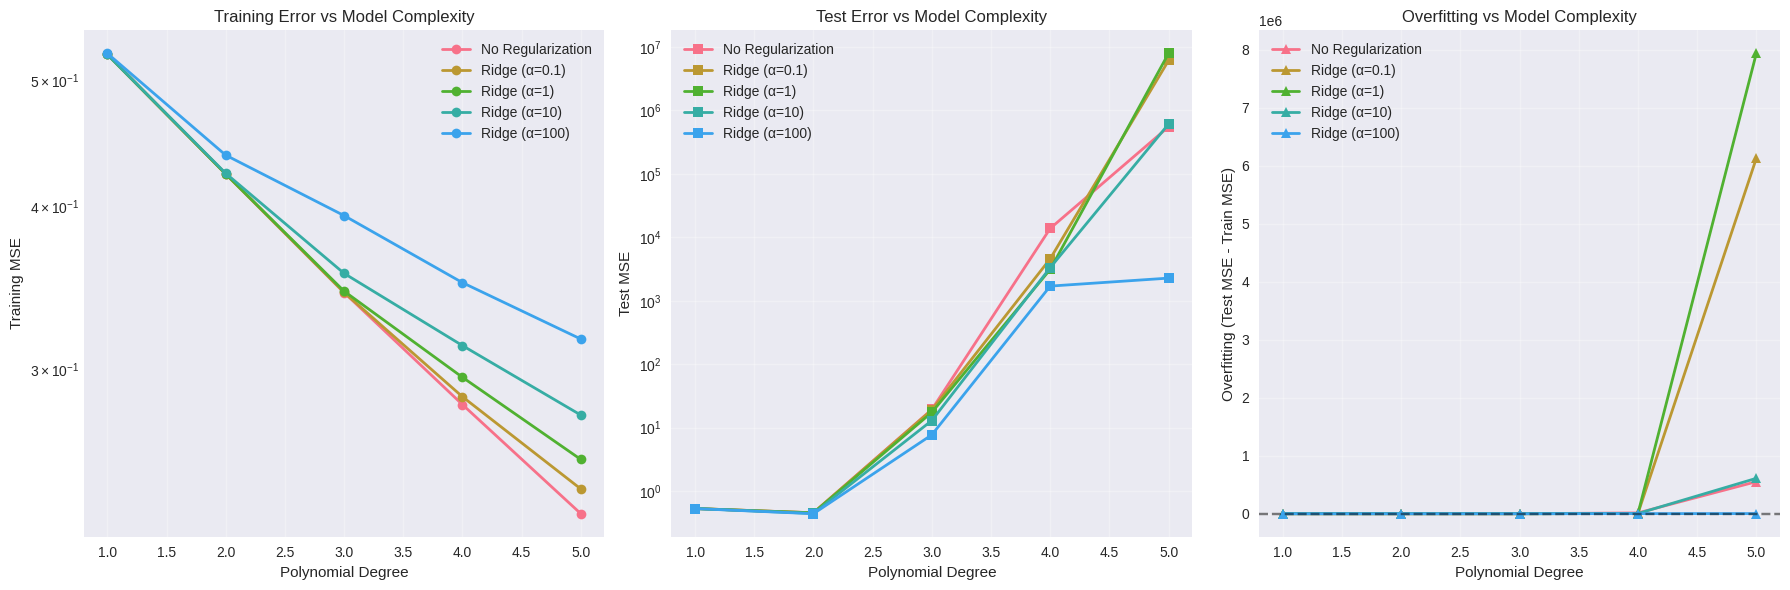

In [11]:
# Visualize the effect of regularization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Training MSE vs Degree for different regularization strengths
for alpha in alpha_values:
    subset = results_df[results_df['alpha'] == alpha]
    label = 'No Regularization' if alpha == 0 else f'Ridge (α={alpha})'
    axes[0].plot(subset['degree'], subset['train_mse'], 'o-', label=label, linewidth=2)

axes[0].set_xlabel('Polynomial Degree')
axes[0].set_ylabel('Training MSE')
axes[0].set_title('Training Error vs Model Complexity')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_yscale('log')

# Plot 2: Test MSE vs Degree for different regularization strengths
for alpha in alpha_values:
    subset = results_df[results_df['alpha'] == alpha]
    label = 'No Regularization' if alpha == 0 else f'Ridge (α={alpha})'
    axes[1].plot(subset['degree'], subset['test_mse'], 's-', label=label, linewidth=2)

axes[1].set_xlabel('Polynomial Degree')
axes[1].set_ylabel('Test MSE')
axes[1].set_title('Test Error vs Model Complexity')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_yscale('log')

# Plot 3: Overfitting (Test - Train) vs Degree
for alpha in alpha_values:
    subset = results_df[results_df['alpha'] == alpha]
    label = 'No Regularization' if alpha == 0 else f'Ridge (α={alpha})'
    axes[2].plot(subset['degree'], subset['overfitting'], '^-', label=label, linewidth=2)

axes[2].set_xlabel('Polynomial Degree')
axes[2].set_ylabel('Overfitting (Test MSE - Train MSE)')
axes[2].set_title('Overfitting vs Model Complexity')
axes[2].legend()
axes[2].grid(True, alpha=0.3)
axes[2].axhline(y=0, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


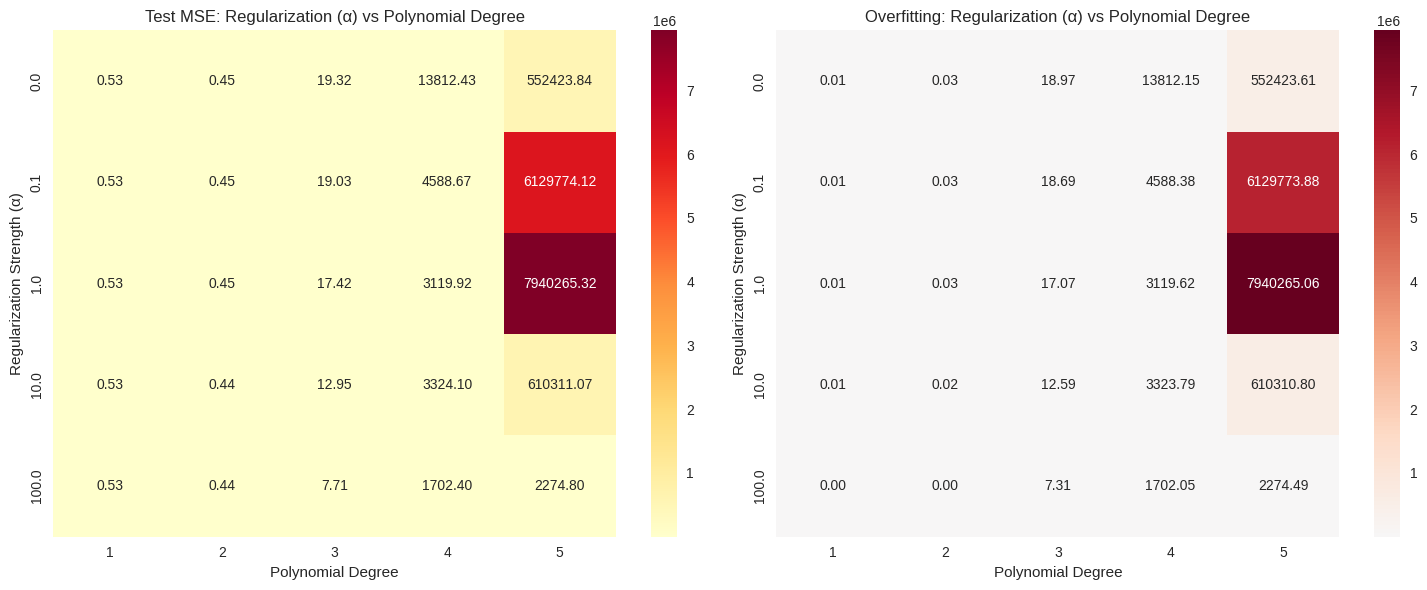

\nBest combination:
Polynomial Degree: 2.0
Regularization (α): 100.0
Test MSE: 0.4399
Overfitting: 0.0019
\nKey Insights:
• Higher regularization (α) reduces overfitting but may increase bias
• Lower regularization allows more flexibility but risks overfitting
• The optimal combination balances both concerns


In [12]:
# Create heatmaps to show the best combination
pivot_test = results_df.pivot(index='alpha', columns='degree', values='test_mse')
pivot_overfitting = results_df.pivot(index='alpha', columns='degree', values='overfitting')

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Test MSE heatmap
sns.heatmap(pivot_test, annot=True, fmt='.2f', cmap='YlOrRd', ax=axes[0])
axes[0].set_title('Test MSE: Regularization (α) vs Polynomial Degree')
axes[0].set_xlabel('Polynomial Degree')
axes[0].set_ylabel('Regularization Strength (α)')

# Overfitting heatmap
sns.heatmap(pivot_overfitting, annot=True, fmt='.2f', cmap='RdBu_r', center=0, ax=axes[1])
axes[1].set_title('Overfitting: Regularization (α) vs Polynomial Degree')
axes[1].set_xlabel('Polynomial Degree')
axes[1].set_ylabel('Regularization Strength (α)')

plt.tight_layout()
plt.show()

# Find the best combination
best_result = results_df.loc[results_df['test_mse'].idxmin()]
print(f"\\nBest combination:")
print(f"Polynomial Degree: {best_result['degree']}")
print(f"Regularization (α): {best_result['alpha']}")
print(f"Test MSE: {best_result['test_mse']:.4f}")
print(f"Overfitting: {best_result['overfitting']:.4f}")

print("\\nKey Insights:")
print("• Higher regularization (α) reduces overfitting but may increase bias")
print("• Lower regularization allows more flexibility but risks overfitting")
print("• The optimal combination balances both concerns")


## 7. Ensemble Methods: Balancing Bias and Variance {#ensemble-methods}

Ensemble methods can provide an excellent balance between bias and variance by combining multiple models.


In [13]:
# Final demonstration: Ensemble methods for bias-variance tradeoff
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

# Use the California Housing dataset for the final comparison
# (Use the already prepared X_train_scaled, y_train from previous cells)

# Create models with different bias-variance characteristics
models = {
    'High Bias\\n(Shallow Tree)': DecisionTreeRegressor(max_depth=2, random_state=42),
    'High Variance\\n(Deep Tree)': DecisionTreeRegressor(max_depth=20, random_state=42),
    'Balanced\\n(Random Forest)': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    'Bagging\\n(Reduced Variance)': BaggingRegressor(DecisionTreeRegressor(max_depth=20),
                                                   n_estimators=100, random_state=42)
}

# Test on the California housing dataset
results = []
for name, model in models.items():
    # Use cross-validation for more robust results
    cv_scores = cross_val_score(model, X_train_scaled, y_train,
                               cv=5, scoring='neg_mean_squared_error')

    # Fit on full training set and test
    model.fit(X_train_scaled, y_train)
    train_pred = model.predict(X_train_scaled)
    test_pred = model.predict(X_test_scaled)

    train_mse = mean_squared_error(y_train, train_pred)
    test_mse = mean_squared_error(y_test, test_pred)
    cv_mse = -cv_scores.mean()
    cv_std = cv_scores.std()

    results.append({
        'Model': name,
        'Train MSE': train_mse,
        'Test MSE': test_mse,
        'CV MSE': cv_mse,
        'CV Std': cv_std,
        'Overfitting': test_mse - train_mse
    })

results_df = pd.DataFrame(results)
print("Model Comparison on California Housing Dataset:")
print(results_df.round(4))

print("\\nDataset context:")
print(f"- Features: {len(X_train_scaled[0])} (median income, house age, rooms, etc.)")
print(f"- Target: House prices in hundreds of thousands of dollars")
print(f"- Training samples: {len(X_train_scaled)}")
print(f"- Test samples: {len(X_test_scaled)}")


Model Comparison on California Housing Dataset:
                         Model  Train MSE  Test MSE  CV MSE  CV Std  \
0    High Bias\n(Shallow Tree)     0.7364    0.7360  0.7480  0.0240   
1   High Variance\n(Deep Tree)     0.0046    0.5332  0.5514  0.0303   
2    Balanced\n(Random Forest)     0.1694    0.2945  0.2995  0.0098   
3  Bagging\n(Reduced Variance)     0.0387    0.2564  0.2702  0.0077   

   Overfitting  
0      -0.0005  
1       0.5286  
2       0.1251  
3       0.2177  
\nDataset context:
- Features: 8 (median income, house age, rooms, etc.)
- Target: House prices in hundreds of thousands of dollars
- Training samples: 14448
- Test samples: 6192


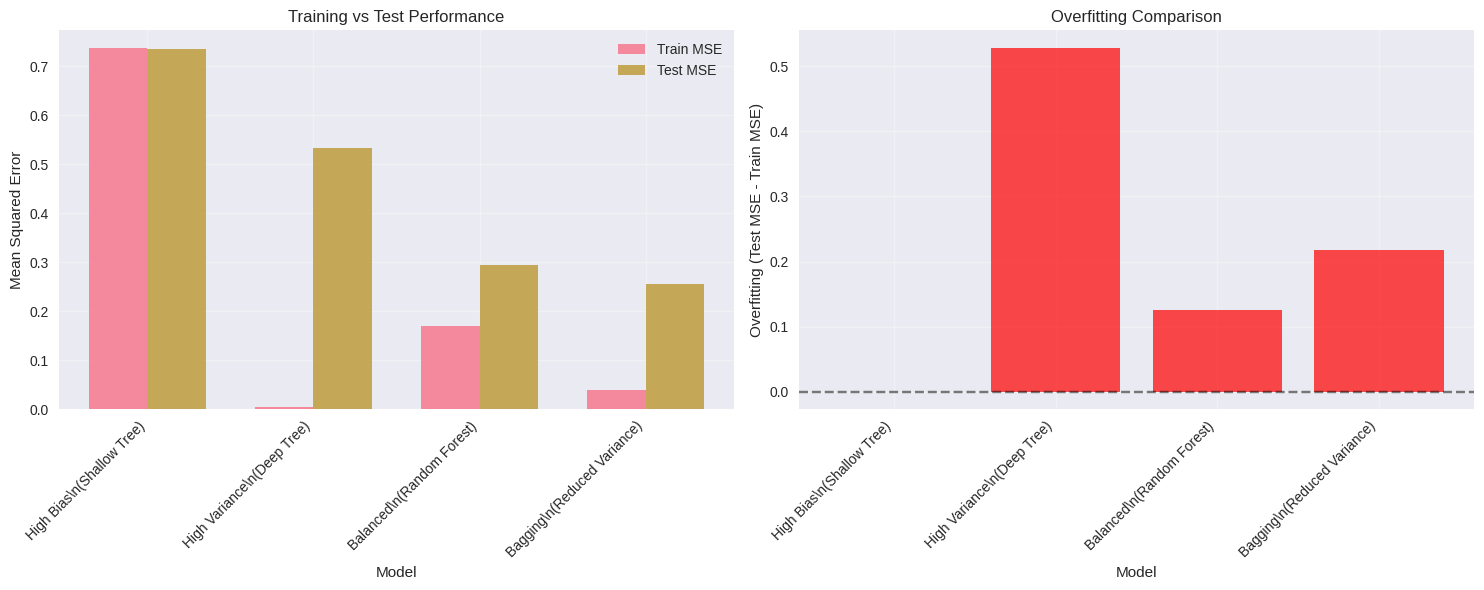

\nEnsemble Method Analysis:
• Shallow Tree: High bias, low variance (underfitting)
• Deep Tree: Low bias, high variance (overfitting)
• Random Forest: Good balance by averaging multiple trees
• Bagging: Reduces variance by averaging predictions


In [14]:
# Visualize the results
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: MSE comparison
x = range(len(results_df))
width = 0.35
axes[0].bar([i - width/2 for i in x], results_df['Train MSE'], width, label='Train MSE', alpha=0.8)
axes[0].bar([i + width/2 for i in x], results_df['Test MSE'], width, label='Test MSE', alpha=0.8)
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Mean Squared Error')
axes[0].set_title('Training vs Test Performance')
axes[0].set_xticks(x)
axes[0].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Overfitting comparison
colors = ['red' if x > 0 else 'green' for x in results_df['Overfitting']]
axes[1].bar(x, results_df['Overfitting'], color=colors, alpha=0.7)
axes[1].set_xlabel('Model')
axes[1].set_ylabel('Overfitting (Test MSE - Train MSE)')
axes[1].set_title('Overfitting Comparison')
axes[1].set_xticks(x)
axes[1].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\\nEnsemble Method Analysis:")
print("• Shallow Tree: High bias, low variance (underfitting)")
print("• Deep Tree: Low bias, high variance (overfitting)")
print("• Random Forest: Good balance by averaging multiple trees")
print("• Bagging: Reduces variance by averaging predictions")


## 8. Summary and Best Practices {#summary}

### Key Takeaways

1. **Bias-Variance Tradeoff**:
   - **Simple models**: High bias, low variance (underfitting)
   - **Complex models**: Low bias, high variance (overfitting)
   - **Goal**: Find the optimal balance for best generalization

2. **Detecting Problems**:
   - **Underfitting**: Poor performance on both training and test data
   - **Overfitting**: Large gap between training and test performance
   - **Good fit**: Good performance on both with small gap

3. **Diagnostic Tools**:
   - **Validation curves**: Tune hyperparameters
   - **Learning curves**: Understand data requirements
   - **Cross-validation**: Robust performance estimates

### Best Practices

#### To Combat Underfitting (High Bias):
- Increase model complexity
- Add more features or polynomial features
- Reduce regularization
- Use more sophisticated algorithms

#### To Combat Overfitting (High Variance):
- Collect more training data
- Reduce model complexity  
- Add regularization (Ridge, Lasso, Elastic Net)
- Use ensemble methods
- Apply early stopping
- Use dropout (for neural networks)

#### General Guidelines:
- Always use cross-validation for model selection
- Plot learning curves to understand data needs
- Start simple, then increase complexity gradually
- Regularization is often your friend
- Ensemble methods can provide excellent bias-variance balance

### The Golden Rule
**"All models are wrong, but some are useful"** - George Box

The goal is not to find the perfect model, but to find a model that generalizes well to new, unseen data while being interpretable and practical for your specific problem.


## 🎯 Interactive Exercise

Try experimenting with the code above! Here are some suggestions:

1. **Modify the datasets**: Try different train/test splits and see how it affects overfitting
2. **Try different polynomial degrees** beyond what we tested (e.g., degree 20, 30)
3. **Experiment with different regularization strengths** in Ridge regression (e.g., α=0.01, 1000)
4. **Use different algorithms** like Support Vector Machines or Neural Networks
5. **Try different features**: In the Auto MPG dataset, try using 'weight' instead of 'horsepower'
6. **Modify tree parameters**: In the Wine dataset, experiment with min_samples_split, min_samples_leaf
7. **Load your own CSV dataset** and apply these concepts to your own data!

## 📚 Further Reading

- **Books**:
  - "The Elements of Statistical Learning" by Hastie, Tibshirani, and Friedman
  - "Pattern Recognition and Machine Learning" by Christopher Bishop
  
- **Online Resources**:
  - Scikit-learn documentation on model evaluation
  - Andrew Ng's Machine Learning Course (Coursera)
  - "Hands-On Machine Learning" by Aurélien Géron

---

**Congratulations!** You now have a solid understanding of the bias-variance tradeoff and how to diagnose and address overfitting and underfitting in machine learning models. These concepts are fundamental to becoming a successful machine learning practitioner!
